# Imports

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [129]:
X_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

X_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

# Process

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import cv2

In [205]:
def transform_to_images(X, gamma=0.1, final_size=(32, 32), mean=0.5, std=0.5):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_gamma_corrected = np.power(X_scaled, gamma) * 255

    X_padded = np.pad(X_gamma_corrected, ((0, 0), (0, 6)), 'constant', constant_values=0)
    images = X_padded.reshape(-1, 8, 8)
    images = images.astype(np.uint8)
    scaled_images = np.array([cv2.resize(img, final_size, interpolation=cv2.INTER_NEAREST) for img in images])
    rgb_images = np.stack([scaled_images] * 3, axis=-1)

    transposed_images = np.transpose(rgb_images, (0, 3, 1, 2))
    transposed_images = (transposed_images / 255.0 - mean) / std

    return transposed_images

In [209]:
def display_transformed_image(transformed_image):
    image = np.transpose(transformed_image, (1, 2, 0))
    
    mean = 0.5
    std = 0.5
    image = image * std + mean

    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [207]:
X_train_images = transform_to_images(X_train)
X_test_images = transform_to_images(X_test)

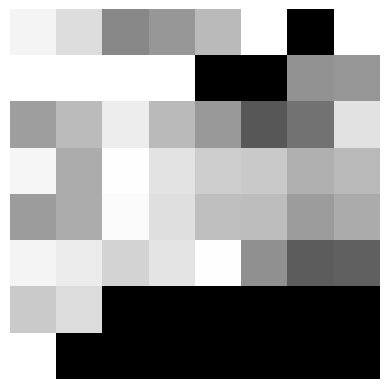

In [210]:
display_transformed_image(X_train_images[0])

# MAE

In [211]:
import torch
import timm
import numpy as np

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

In [212]:
class ImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # Convert to tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image

In [251]:
def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes

class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=12,
                 num_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(3, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 num_layer=4,
                 num_head=3,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2)
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.image_size = image_size
        self.patch_size = patch_size
        
        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)

        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        img = img.mean(dim=1, keepdim=True).expand(-1, 3, -1, -1) # mean to grayscale
        
        mask = self.patch2img(mask)

        return img, mask

class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=32,
                 patch_size=2,
                 emb_dim=192,
                 encoder_layer=12,
                 encoder_head=3,
                 decoder_layer=4,
                 decoder_head=3,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits

# Short Test

In [252]:
shuffle = PatchShuffle(0.75)
a = torch.rand(16, 2, 10)
b, forward_indexes, backward_indexes = shuffle(a)
print(b.shape)

img = torch.rand(2, 3, 32, 32)
encoder = MAE_Encoder()
decoder = MAE_Decoder()
features, backward_indexes = encoder(img)
print(forward_indexes.shape)
predicted_img, mask = decoder(features, backward_indexes)
print(predicted_img.shape)
loss = torch.mean((predicted_img - img) ** 2 * mask / 0.75)
print(loss)

torch.Size([4, 2, 10])
torch.Size([16, 2])
torch.Size([2, 3, 32, 32])
tensor(0.3206, grad_fn=<MeanBackward0>)


# Pretraining

In [253]:
from torch.utils.data import TensorDataset, DataLoader

import os
import argparse
import math
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor, Compose, Normalize
from tqdm import tqdm

In [261]:
seed = 42
batch_size = 4096
max_device_batch_size = 512
base_learning_rate = 1.5e-4
weight_decay = 0.05
mask_ratio = 0.75
total_epoch = 10
warmup_epoch = 200

batch_size = 4096
load_batch_size = 512
steps_per_update = batch_size // load_batch_size
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [262]:
X_train_tensor = torch.tensor(X_train_images, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=load_batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=load_batch_size, shuffle=False, num_workers=4)

In [263]:
batch_size = batch_size
load_batch_size = min(max_device_batch_size, batch_size)

assert batch_size % load_batch_size == 0
steps_per_update = batch_size // load_batch_size

#train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
#val_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=Compose([ToTensor(), Normalize(0.5, 0.5)]))
#dataloader = torch.utils.data.DataLoader(train_dataset, load_batch_size, shuffle=True, num_workers=4)
dataloader=train_loader

writer = SummaryWriter(os.path.join('logs', 'cifar10', 'mae-pretrain'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MAE_ViT(mask_ratio=mask_ratio).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=base_learning_rate * batch_size / 256, betas=(0.9, 0.95), weight_decay=weight_decay)
lr_func = lambda epoch: min((epoch + 1) / (warmup_epoch + 1e-8), 0.5 * (math.cos(epoch / total_epoch * math.pi) + 1))
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func, verbose=True)

step_count = 0
optim.zero_grad()
for e in range(total_epoch):
    model.train()
    losses = []
    for img, label in tqdm(iter(dataloader)):
        step_count += 1
        img = img.to(device)
        predicted_img, mask = model(img)
        loss = torch.mean((predicted_img - img) ** 2 * mask) / mask_ratio
        loss.backward()
        if step_count % steps_per_update == 0:
            optim.step()
            optim.zero_grad()
        losses.append(loss.item())
    lr_scheduler.step()
    avg_loss = sum(losses) / len(losses)

    current_lr = lr_scheduler.get_last_lr()[0]
    print(f'Epoch {e+1}/{total_epoch}, Learning Rate: {current_lr:.6f}, Average Training Loss: {avg_loss:.4f}')
    
    writer.add_scalar('mae_loss', avg_loss, global_step=e)
    print(f'In epoch {e}, average traning loss is {avg_loss}.')

100%|██████████| 877/877 [03:54<00:00,  3.73it/s]

Epoch 1/10, Learning Rate: 0.000024, Average Training Loss: 0.4693
In epoch 0, average traning loss is 0.4692647380153293.



100%|██████████| 877/877 [03:57<00:00,  3.69it/s]

Epoch 2/10, Learning Rate: 0.000036, Average Training Loss: 0.1822
In epoch 1, average traning loss is 0.18216178225546634.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 3/10, Learning Rate: 0.000048, Average Training Loss: 0.1347
In epoch 2, average traning loss is 0.1347071622650191.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 4/10, Learning Rate: 0.000060, Average Training Loss: 0.1113
In epoch 3, average traning loss is 0.11125801470525724.



100%|██████████| 877/877 [03:55<00:00,  3.72it/s]

Epoch 5/10, Learning Rate: 0.000072, Average Training Loss: 0.0986
In epoch 4, average traning loss is 0.09855007239221303.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 6/10, Learning Rate: 0.000084, Average Training Loss: 0.0836
In epoch 5, average traning loss is 0.08355684151093527.



100%|██████████| 877/877 [03:55<00:00,  3.72it/s]

Epoch 7/10, Learning Rate: 0.000096, Average Training Loss: 0.0704
In epoch 6, average traning loss is 0.07043039311517875.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 8/10, Learning Rate: 0.000108, Average Training Loss: 0.0653
In epoch 7, average traning loss is 0.065326296345266.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 9/10, Learning Rate: 0.000059, Average Training Loss: 0.0551
In epoch 8, average traning loss is 0.05513790624477437.



100%|██████████| 877/877 [03:56<00:00,  3.71it/s]

Epoch 10/10, Learning Rate: 0.000000, Average Training Loss: 0.0397
In epoch 9, average traning loss is 0.03973021445118375.


In [265]:
torch.save(model, 'mae.pth')

# Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

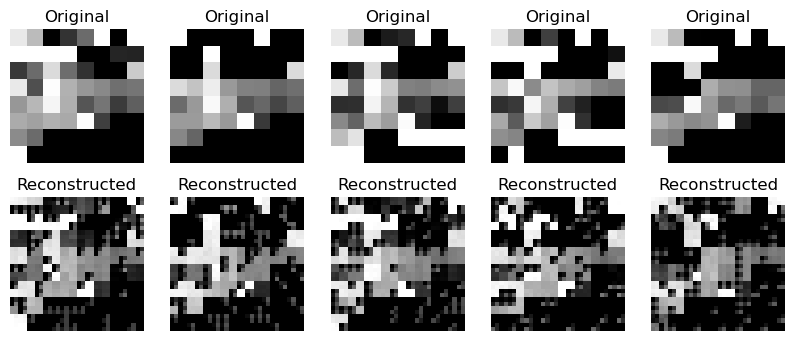

In [264]:
def visualize_reconstruction(model, test_loader, device, num_images=8):
    model.eval()

    data_iter = iter(test_loader)
    images, _ = next(data_iter)

    images = images.to(device)

    with torch.no_grad(): 
        reconstructed_images, _ = model(images)

    images = images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):

        axes[0, i].imshow(images[i].permute(1, 2, 0).numpy())
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        axes[1, i].imshow(reconstructed_images[i].permute(1, 2, 0).numpy())
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")

    plt.show()

visualize_reconstruction(model, test_loader, device, 5)

# Extract Features

In [277]:
def extract_features(encoder, data_loader, device):
    encoder.eval()
    features_list = []
    labels_list = [] 
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Extracting features"): 
            inputs = inputs.to(device)
            labels = labels.to(device) 
            features, _ = encoder(inputs)

            features = features[0].cpu().numpy()
            labels = labels.cpu().numpy()  
            features_list.append(features)
            labels_list.append(labels)

    features_array = np.vstack(features_list)
    labels_array = np.concatenate(labels_list)
    return features_array, labels_array

encoder = model.encoder

X_train_features, y_train_features = extract_features(encoder, train_loader, device)
X_test_features, y_test_features = extract_features(encoder, test_loader, device)

Extracting features: 100%|██████████| 274/274 [00:14<00:00, 18.79it/s]


In [282]:
X_train_features.shape

(448735, 192)

In [279]:
len(y_train_features)

448735

# Model

In [487]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time

In [283]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 array([ 30073,   1823,   1339,  14562,  14165,     18,   3246,  24286,
         13316,     72,   3810, 259964,  49365,    650,  20234,   1354,
           294,    733,   9431]))

In [284]:
y_test_binary = np.where(y_test == 11, 'normal', 'anomaly')

In [507]:
normal_data = X_train_features[y_train == 11] # 11 is normal class

In [508]:
len(normal_data)

259964

In [287]:
def evaluate_model(model, y_test, y_pred):
    positive_class = "normal"
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision = precision_score(y_test, y_pred, pos_label=positive_class)
    recall = recall_score(y_test, y_pred, pos_label=positive_class)
    f1 = f1_score(y_test, y_pred, pos_label=positive_class)
    
    metrics = {
        'model': [model],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1],
    }
    
    return metrics

In [303]:
y_test_binary = np.where(y_test_features == 11, 'normal', 'anomaly')

# SGDOCSVM

In [288]:
from sklearn.linear_model import SGDOneClassSVM

In [423]:
sgd_svm = SGDOneClassSVM(nu=0.9, verbose=3, eta0=0.3, learning_rate='optimal')
sgd_svm.fit(X_train_features, y_train_features)

-- Epoch 1
Norm: 1.97, NNZs: 192, Bias: -22.075314, T: 448735, Avg. loss: 0.026048
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 2.07, NNZs: 192, Bias: -23.331380, T: 897470, Avg. loss: 0.032506
Total training time: 0.45 seconds.
-- Epoch 3
Norm: 2.13, NNZs: 192, Bias: -24.063186, T: 1346205, Avg. loss: 0.035521
Total training time: 0.67 seconds.
-- Epoch 4
Norm: 2.18, NNZs: 192, Bias: -24.581211, T: 1794940, Avg. loss: 0.037145
Total training time: 0.90 seconds.
-- Epoch 5
Norm: 2.21, NNZs: 192, Bias: -24.982204, T: 2243675, Avg. loss: 0.038732
Total training time: 1.12 seconds.
-- Epoch 6
Norm: 2.24, NNZs: 192, Bias: -25.309588, T: 2692410, Avg. loss: 0.039678
Total training time: 1.34 seconds.
Convergence after 6 epochs took 1.34 seconds


SGDOneClassSVM(eta0=0.3, nu=0.9, verbose=3)

In [426]:
y_pred_sgd_svm = sgd_svm.predict(X_test_features)
y_preds_sgd_svm_binary = np.where(y_pred_sgd_svm == 1, 'normal', 'anomaly')

In [427]:
results_sgd_svm = pd.DataFrame(evaluate_model("SGDOCSVM", y_test_binary, y_preds_sgd_svm_binary))
results_sgd_svm

,model,accuracy,precision,recall,f1
0,SGDOCSVM,0.607031,0.600681,0.959601,0.738859


# IF

In [428]:
from sklearn.ensemble import IsolationForest

In [480]:
model_if = IsolationForest(n_estimators=100, max_samples=256, contamination=0.05, verbose=1)
model_if.fit(X_train_features, y_train_features)

IsolationForest(contamination=0.05, max_samples=256, verbose=1)

In [481]:
y_pred_if = model_if.predict(X_test_features)
y_preds_if_binary = np.where(y_pred_if == 1, 'normal', 'anomaly')

In [482]:
results_if = pd.DataFrame(evaluate_model("IF", y_test_binary, y_preds_if_binary))
results_if

,model,accuracy,precision,recall,f1
0,IF,0.604414,0.595937,0.985069,0.742615


# PCA Reconstruction

In [483]:
from sklearn.decomposition import PCA

In [497]:
pca_start = time()

pca = PCA(n_components=2, whiten=True, svd_solver='auto')

normal_data_pca = pca.fit_transform(normal_data)
normal_data_reconstructed = pca.inverse_transform(normal_data_pca)

reconstruction_error = np.mean((normal_data - normal_data_reconstructed) ** 2, axis=1)

threshold = np.percentile(reconstruction_error, 95)

X_test_pca = pca.transform(X_test)
X_test_reconstructed = pca.inverse_transform(X_test_pca)
X_test_reconstruction_error = np.mean((X_test - X_test_reconstructed) ** 2, axis=1)

print(f"seconds: {time() - pca_start}")

seconds: 0.24628782272338867


In [498]:
y_pred_test_pca = np.where(X_test_reconstruction_error > threshold, 'anomaly', 'normal')
y_test_converted_pca = np.where(y_test == 11, 'normal', 'anomaly')

In [499]:
pca_df = pd.DataFrame(evaluate_model('PCA Reconstruction', y_test_converted_pca, y_pred_test_pca))
pca_df

,model,accuracy,precision,recall,f1
0,PCA Reconstruction,0.872937,0.848701,0.950036,0.896514


# LOF

In [511]:
from sklearn.neighbors import LocalOutlierFactor

In [529]:
lof_model = LocalOutlierFactor(n_neighbors=100, contamination=0.001)
lof_model.fit(X_train_features, y_train_features)

LocalOutlierFactor(contamination=0.001, n_neighbors=100)

In [530]:
y_pred_lof = lof_model.fit_predict(X_test_features)
y_preds_lof_binary = np.where(y_pred_lof == 1, 'normal', 'anomaly')

In [531]:
lof_df = pd.DataFrame(evaluate_model("LOF", y_test_binary, y_preds_lof_binary))
lof_df

,model,accuracy,precision,recall,f1
0,LOF,0.57942,0.579453,0.999212,0.733527
